# Lab 03 : Policy Network with Global Reward - demo


In [ ]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/gdrive')
    file_name = 'policy_global_reward_demo.ipynb'
    import subprocess
    path_to_file = subprocess.check_output('find . -type f -name ' + str(file_name), shell=True).decode("utf-8")
    print(path_to_file)
    path_to_file = path_to_file.replace(file_name,"").replace('\n',"")
    os.chdir(path_to_file)
    !pwd

In [1]:

import torch
import torch.nn as nn
torch.manual_seed(torch.randint(10000,())) # random seed for pythorch random generator

import time
import numpy as np

import os
import pickle

import gym

import matplotlib
import matplotlib.pyplot as plt
from IPython import display

from collections import namedtuple
import random
from itertools import count


# Dataset

In [2]:

#Env parameters
env_seed = 1
render = True # display on
render = False # display off

#Initialize the environment with the same seed/initialization value
env = gym.make('CartPole-v0')
env.seed(env_seed)

#Reset the environment
state = env.reset() 
print('init state:',state)

#Rollout one episode until it finishes 
for t in count():  
    action = torch.LongTensor(1).random_(0,2).item() # randomly generated action=a in {0,1}
    state, reward, done, _ = env.step(action) # receive next state=s' and reward=r
    print('t=',t, 'action=',action, 'state=',np.array_str(state, precision=5), 'reward=',reward, 'done=',done )
    if render:
        env.render() # see the state
    if done:
        break


init state: [ 0.03073904  0.00145001 -0.03088818 -0.03131252]
t= 0 action= 1 state= [ 0.03077  0.197   -0.03151 -0.33358] reward= 1.0 done= False
t= 1 action= 0 state= [ 0.03471  0.00234 -0.03819 -0.051  ] reward= 1.0 done= False
t= 2 action= 0 state= [ 0.03475 -0.19221 -0.03921  0.2294 ] reward= 1.0 done= False
t= 3 action= 0 state= [ 0.03091 -0.38675 -0.03462  0.50946] reward= 1.0 done= False
t= 4 action= 1 state= [ 0.02318 -0.19116 -0.02443  0.20607] reward= 1.0 done= False
t= 5 action= 1 state= [ 0.01935  0.0043  -0.02031 -0.09422] reward= 1.0 done= False
t= 6 action= 0 state= [ 0.01944 -0.19052 -0.02219  0.19199] reward= 1.0 done= False
t= 7 action= 1 state= [ 0.01563  0.00491 -0.01835 -0.10761] reward= 1.0 done= False
t= 8 action= 1 state= [ 0.01573  0.20029 -0.0205  -0.40603] reward= 1.0 done= False
t= 9 action= 1 state= [ 0.01973  0.3957  -0.02862 -0.7051 ] reward= 1.0 done= False
t= 10 action= 1 state= [ 0.02765  0.5912  -0.04273 -1.00666] reward= 1.0 done= False
t= 11 action=

# Define the policy network

In [3]:

# class of policy network
class Policy_NN(nn.Module): 
    
    def __init__(self, net_parameters):
        super(Policy_NN, self).__init__()
        input_dim = net_parameters['input_dim']
        hidden_dim = net_parameters['hidden_dim']
        output_dim = net_parameters['output_dim']
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        actions_score = self.fc2(x)
        actions_prob = torch.softmax(actions_score, dim=1)
        return actions_prob
    
    def select_action(self, state): # select action w/ policy network
        probs = self.forward(state) # probability of action a in state s
        bernoulli_sampling = torch.distributions.Categorical(probs) 
        action = bernoulli_sampling.sample() # sample action a with Bernoulli sampling
        log_prob = bernoulli_sampling.log_prob(action) # compute log prob of selected action
        action = action.item()
        return action, log_prob
    
    def loss(self, batch_rewards, batch_log_probs, batch_rewards_baseline):
        nb_episodes_per_batch = len(batch_rewards)
        batch_episode_rewards = torch.Tensor(batch_rewards)
        batch_episode_rewards_baseline = torch.Tensor(batch_rewards_baseline)
        batch_episode_rewards -= batch_episode_rewards_baseline # compare current model w.r.t. baseline model
        batch_policy_losses = []
        for episode in range(nb_episodes_per_batch):
            episode_reward = batch_episode_rewards[episode]
            episode_log_probs = torch.stack(batch_log_probs[episode])
            policy_loss = - episode_log_probs.sum() * episode_reward
            batch_policy_losses.append(policy_loss)
        loss = torch.stack(batch_policy_losses).mean()
        return loss
        

        
# class of rollout episodes
class Rollout_Episodes():
    
    def __init__(self):
        super(Rollout_Episodes, self).__init__()
        
    def rollout_batch_episodes(self, env, opt_parameters, policy_net):
        # storage structure of all episodes (w/ different lengths):
        #   batch_rewards =         [    - ,       -      , ...,    -   ]
        #   batch_log_probs =       [ [- - -] , [- - - -] , ... , [- -] ]
        #   batch_episode_lengths = [    - ,       -      , ...,    -   ]
        nb_episodes_per_batch = opt_parameters['nb_episodes_per_batch']
        env_seeds = opt_parameters['env_seed']
        batch_rewards = []
        batch_log_probs = []
        batch_episode_lengths = []
        for episode in range(nb_episodes_per_batch):
            rewards = []
            log_probs = []
            env.seed(env_seeds[episode].item()) # start with random seed
            state = env.reset() # reset environment
            for t in range(1000): # rollout one episode
                state_pytorch = torch.from_numpy(state).float().unsqueeze(0) # state=s
                action, log_prob = policy_net.select_action(state_pytorch) # select action=a from state=s
                state, reward, done, _ = env.step(action) # receive next state=s' and reward=r
                rewards.append(reward)
                log_probs.append(log_prob)
                if done:
                    batch_episode_lengths.append(t)
                    batch_rewards.append(t)
                    batch_log_probs.append(log_probs)
                    break
        return batch_rewards, batch_log_probs, batch_episode_lengths

        
    
# network parameters
net_parameters = {}
net_parameters['input_dim'] = 4
net_parameters['hidden_dim'] = 128
net_parameters['output_dim'] = 2

# instantiate network
policy_net = Policy_NN(net_parameters)
print(policy_net)
baseline_policy_net = Policy_NN(net_parameters)
baseline_policy_net.load_state_dict(policy_net.state_dict())
baseline_policy_net = baseline_policy_net.eval()
print(baseline_policy_net)


# instantiate rollout
rollout_policy_net = Rollout_Episodes()
rollout_baseline_policy_net = Rollout_Episodes()

# optimization parameters
opt_parameters = {}
opt_parameters['nb_episodes_per_batch'] = 3
opt_parameters['env_seed'] = torch.LongTensor(opt_parameters['nb_episodes_per_batch']).random_(1,10000)

env = gym.make('CartPole-v0')

batch_rewards, batch_log_probs, batch_episode_lengths = rollout_policy_net.rollout_batch_episodes(env, opt_parameters, policy_net)
#print('batch_rewards:',batch_rewards)
#print('batch_log_probs:',batch_log_probs)
print('batch_episode_lengths:',batch_episode_lengths)


Policy_NN(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)
Policy_NN(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)
batch_episode_lengths: [11, 18, 15]


# Test forward pass

In [4]:

# optimization parameters
opt_parameters = {}
opt_parameters['lr'] = 0.001
opt_parameters['nb_episodes_per_batch'] = 3
opt_parameters['nb_batches_per_epoch'] = 10
opt_parameters['env_seed'] = torch.LongTensor(opt_parameters['nb_episodes_per_batch']).random_(1,10000)
opt_parameters['gamma'] = 0.99

batch_rewards, batch_log_probs, batch_episode_lengths = rollout_policy_net.rollout_batch_episodes(env, opt_parameters, policy_net)
print('batch_episode_lengths:',batch_episode_lengths)

batch_rewards_baseline, batch_log_probs_baseline, batch_episode_lengths_baseline = rollout_baseline_policy_net.rollout_batch_episodes(env, opt_parameters, policy_net)
print('batch_episode_lengths:',batch_episode_lengths_baseline)


batch_episode_lengths: [17, 19, 9]
batch_episode_lengths: [12, 28, 16]


# Test backward pass

In [5]:

# Loss
loss = policy_net.loss(batch_rewards, batch_log_probs, batch_rewards_baseline)
print('loss:',loss)

# Backward pass
lr = opt_parameters['lr']
optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr)
optimizer.zero_grad()
loss.backward()
optimizer.step()


loss: tensor(-35.9107, grad_fn=<MeanBackward0>)


# Train one epoch

In [6]:

def train_one_epoch(env, policy_net, baseline_policy_net, opt_parameters):
    """
    train one epoch
    """    
    policy_net.train()
    baseline_policy_net.eval()
    rollout_policy = Rollout_Episodes()
    rollout_baseline_policy = Rollout_Episodes()
    epoch_loss = 0
    nb_data = 0
    epoch_episode_length = 0
    epoch_episode_lengths = []
    nb_batches_per_epoch = opt_parameters['nb_batches_per_epoch']
    for iter in range(nb_batches_per_epoch):
        opt_parameters['env_seed'] = torch.LongTensor(opt_parameters['nb_episodes_per_batch']).random_(1,10000)
        batch_rewards, batch_log_probs, batch_episode_lengths = \
            rollout_policy.rollout_batch_episodes(env, opt_parameters, policy_net)
        batch_rewards_baseline, batch_log_probs_baseline, batch_episode_lengths_baseline = \
            rollout_baseline_policy.rollout_batch_episodes(env, opt_parameters, baseline_policy_net)
        loss = policy_net.loss(batch_rewards, batch_log_probs, batch_rewards_baseline)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
        nb_data += len(batch_episode_lengths)
        epoch_episode_length += torch.tensor(batch_episode_lengths).float().sum()
        epoch_episode_lengths.append(epoch_episode_length)
    epoch_loss /= nb_data
    epoch_episode_length /= nb_data
    return epoch_loss, epoch_episode_length, epoch_episode_lengths



# Train NN

In [7]:

# network parameters
net_parameters = {}
net_parameters['input_dim'] = 4
net_parameters['hidden_dim'] = 256
net_parameters['output_dim'] = 2

# instantiate network
policy_net = Policy_NN(net_parameters)
print(policy_net)
baseline_policy_net = Policy_NN(net_parameters)
baseline_policy_net = baseline_policy_net.eval()
print(baseline_policy_net)

# optimization parameters
opt_parameters = {}
opt_parameters['lr'] = 0.0005
opt_parameters['nb_episodes_per_batch'] = 5
opt_parameters['nb_batches_per_epoch'] = 10

optimizer = torch.optim.Adam(policy_net.parameters(), lr=opt_parameters['lr'])

# select maximum episode length to learn
env = gym.make('CartPole-v0')
env._max_episode_steps = 400 # 200 400
env.spec.reward_threshold = 0.975* env._max_episode_steps
print('env._max_episode_steps',env._max_episode_steps)

# train loop
all_epoch_lengths = []
start = time.time()
for epoch in range(500): 
    
    # train one epoch
    epoch_train_loss, epoch_episode_length, epoch_episode_lengths = \
        train_one_epoch(env, policy_net, baseline_policy_net, opt_parameters)

    # update baseline if current policy better
    if epoch>0 and (not epoch%2):
        opt_parameters['env_seed'] = torch.LongTensor(10).random_(1,10000)
        _, _, batch_episode_lengths = Rollout_Episodes().rollout_batch_episodes(env, opt_parameters, policy_net)
        _, _, batch_episode_lengths_baseline = Rollout_Episodes().rollout_batch_episodes(env, opt_parameters, baseline_policy_net)
        if torch.Tensor(batch_episode_lengths).mean() > torch.Tensor(batch_episode_lengths_baseline).mean():
            print('UPDATE BASELINE - epoch:',epoch)
            baseline_policy_net.load_state_dict(policy_net.state_dict())
        else:
            print('NO UPDATE BASELINE - epoch:',epoch)
    
    # stop training when reward is high
    if epoch_episode_length > env.spec.reward_threshold:
        print('Training done.')
        print("Last episode length is {}, epoch is {}".
              format(epoch_episode_length, epoch))
        break

    # print intermediate info
    if not epoch%1:
        print('Epoch: {}, time: {:.4f}, train_loss: {:.4f}, episode_length: {:.4f}'.format(epoch, time.time()-start, epoch_train_loss, epoch_episode_length))
        print('           policy net eval: {:.4f}, baseline policy net eval: {:.4f}'.format(torch.Tensor(batch_episode_lengths).mean().item(), torch.Tensor(batch_episode_lengths_baseline).mean().item() ))
      
    # plot all epochs
    all_epoch_lengths.append(epoch_episode_length)
    if not epoch%1:
        plt.figure(2)
        plt.title('Training...')
        plt.xlabel('Epochs')
        plt.ylabel('Length of episodes batch')
        plt.plot(torch.Tensor(all_epoch_lengths).numpy())
        plt.pause(0.001)
        display.clear_output(wait=True)


UPDATE BASELINE - epoch: 48
Training done.
Last episode length is 390.6000061035156, epoch is 48


Last episode length is 390.6000061035156, epoch is 48


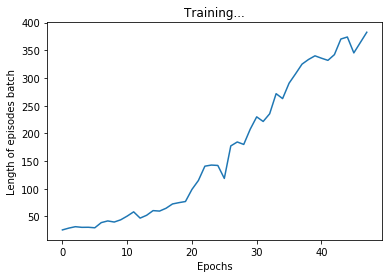

In [8]:
# Final plot
plt.figure(2)
plt.title('Training...')
plt.xlabel('Epochs')
plt.ylabel('Length of episodes batch')
plt.plot(torch.Tensor(all_epoch_lengths).numpy())
print("Last episode length is {}, epoch is {}".format(epoch_episode_length, epoch))
       

# Run it longer

In [16]:

env._max_episode_steps = 5000

state = env.reset() # reset environment
for t in range(env._max_episode_steps): # rollout one episode until it finishes or stop after 200 steps
    state_pytorch = torch.from_numpy(state).float().unsqueeze(0) # state=s
    action, _ = policy_net.eval().select_action(state_pytorch)
    state, reward, done, _ = env.step(action) # receive next state=s' and reward=r
    env.render() # visualize state
    if done:
        print(t)
        break
        

1306
